In [2]:
library(tidyverse)
library(ComplexHeatmap)
library(here)
options(here.quiet = TRUE)

In [3]:
df <-read.delim("../data/baseline_263_visit_clinical.txt")

# Format the categorical variable to appropriate factor levels.
df <- df %>%
  mutate(
    Sex = d_pt_sex,
    Age = d_dx_amm_age,
    BMI = d_dx_amm_bmi,
    Transplant = d_amm_tx_asct_1st,
    PFS = censpfs,
    PFS.time = ttcpfs,
    OS = censos,
    OS.time = ttcos,
    Treatment = case_when(
      d_tx_induction_cat == "chemo_imid_pi_steroid" ~ "imid_pi_steroid",
      d_tx_induction_cat == "chemo_pi_steroid" ~ "pi_steroid",
      TRUE ~ d_tx_induction_cat
    ),
    risk = case_when(
      davies_based_risk %in% c("no_risk_data", "not_calculable") ~ NA_character_,
      TRUE ~ as.character(davies_based_risk)
    ),
    ECOG = case_when(
      d_dx_amm_ecog %in% c("3", "4") ~ ">=3",
      TRUE ~ as.character(d_dx_amm_ecog)
    ),
    Race = case_when(
      d_pt_race_1 %in% c("asian_nos", "unknown") ~ "others/unknown",
      d_pt_race_1 %in% c("black_african_american") ~ "black",
      TRUE ~ as.character(d_pt_race_1)
    ),
    ISS_stage = case_when(
      d_dx_amm_iss_stage %in% c("1") ~ "stage I",
      d_dx_amm_iss_stage %in% c("2") ~ "stage II",
      d_dx_amm_iss_stage %in% c("3") ~ "stage III",
      TRUE ~ as.character(d_dx_amm_iss_stage)
    )
  ) %>%
  mutate(
    Treatment = factor(Treatment, levels = c("pi_steroid", "imid_pi_steroid", "imid_steroid")),
    risk = factor(risk, levels = c("standard_risk", "high_risk")),
    ECOG = factor(ECOG, levels = c("0", "1", "2", ">=3")),
    Race = factor(Race, levels = c("white", "black", "others/unknown")),
    ISS_stage = factor(ISS_stage, levels = c("stage I", "stage II", "stage III"))
  ) %>%
  mutate(risk_group = case_when(
    risk == "standard_risk" ~ "SR",
    risk == "high_risk" ~ "HR",
    TRUE ~ risk  # Keeps other risk values unchanged (if needed)
  ))



# Display the first few rows of the transformed data frame
df %>%
  select(risk_group,progression_group)%>% table()

          progression_group
risk_group Inc NP  P RP
        HR  19 32 32 40
        SR  20 40 29 19

In [4]:
# Filter df for "SR" risk
SR_id <- df %>%
  filter(risk_group == "SR") %>%
  pull(public_id)  # This extracts just the public_id as a vector

# Filter df for "HR" risk 
HR_id <- df %>%
  filter(risk_group == "HR") %>%
  pull(public_id)  # This extracts just the public_id as a vector


# Filter df for "SR" risk 
RP_id <- df %>%
  filter(progression_group == "RP") %>%
  pull(public_id)  # This extracts just the public_id as a vector

# Filter df for "HR" risk 
NP_id <- df %>%
  filter(progression_group == "NP") %>%
  pull(public_id) 


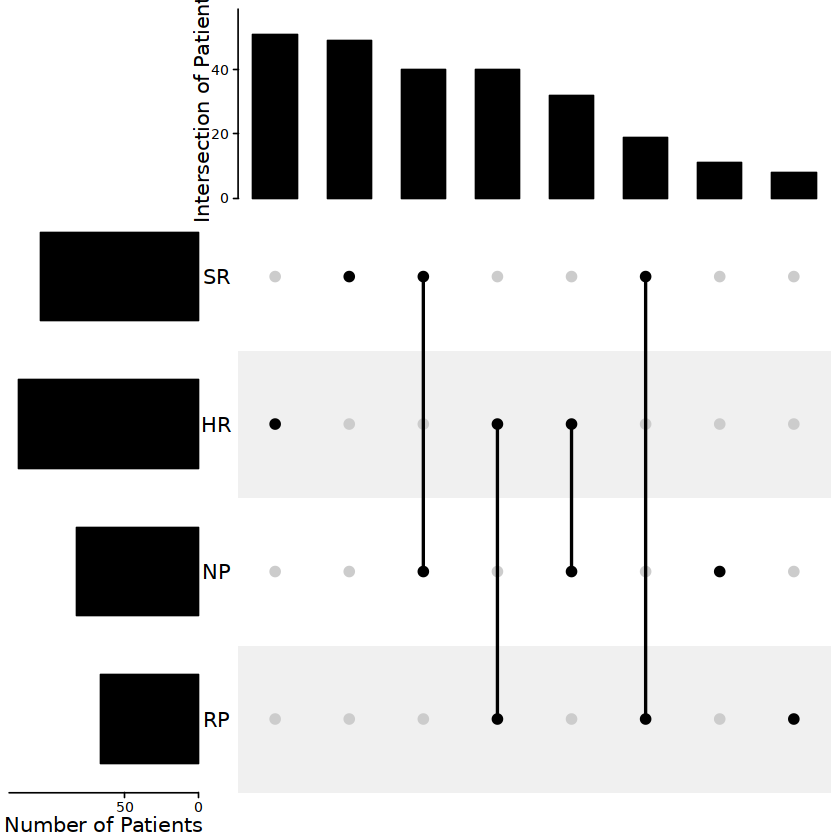

In [5]:
lt = list(SR = SR_id,
          HR = HR_id,
          RP = RP_id,
          NP = NP_id)
m = make_comb_mat(lt)

ss = set_size(m)
cs = comb_size(m)

# Define specific order of the sets
desired_order <- c("SR", "HR", "NP", "RP")

ht = UpSet(m,
    #set_order = order(ss),
    set_order = desired_order,
    comb_order = order(-cs),
    top_annotation = HeatmapAnnotation(
        "Intersection of Patients" = anno_barplot(cs, 
            ylim = c(0, max(cs)*1.1),
            border = FALSE, 
            gp = gpar(fill = "black"), 
            height = unit(4, "cm")
        ), 
        annotation_name_side = "left", 
        annotation_name_rot = 90),
    left_annotation = rowAnnotation(
        "Number of Patients" = anno_barplot(-ss, 
            baseline = 0,
            axis_param = list(
                at = c(0, -50, -100 -150),
                labels = c(0, 50, 100, 150),
                labels_rot = 0),
            border = FALSE, 
            gp = gpar(fill = "black"), 
            width = unit(4, "cm")
        ),
        set_name = anno_text(set_name(m), 
            location = 0.5, 
            just = "center",
            width = max_text_width(set_name(m)) + unit(1, "mm"))
    ), 
    right_annotation = NULL,
    show_row_names = FALSE)
ht = draw(ht)
od = column_order(ht)

